In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker as mtick
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm.auto import tqdm

import fannypack.utils as utils
from lib import dpf, panda_models, panda_datasets, panda_training, omnipush_datasets, fusion, fusion_pf

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

In [14]:
def get_dpf(experiment_name, checkpoint_label="phase_3_end_to_end_trained"):
    # Create model
    dynamics_model = panda_models.PandaDynamicsModel(units=32)
    measurement_model = panda_models.PandaMeasurementModel(units=64)

    pf_model = panda_models.PandaParticleFilterNetwork(
        dynamics_model,
        measurement_model
    )

    # Create buddy & load checkpoint
    buddy = utils.Buddy(experiment_name, pf_model)
    buddy.load_checkpoint(label=checkpoint_label)
    return buddy, pf_model

def get_dpf_fusion(experiment_name, checkpoint_label="phase_4_e2e_joint"):
    # Create model(s)
    pf_image_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['gripper_force']),
#         panda_models.PandaMeasurementModel(units=64, missing_modalities=['gripper_force', 'gripper_pos']),
    )
    pf_force_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['image']),
    )
    weight_model = fusion.CrossModalWeights(units=32, state_dim=1)

    pf_fusion_model = fusion_pf.ParticleFusionModel(
        pf_image_model,
        pf_force_model,
        weight_model
    )
    
    # Create buddy & load checkpoint
    buddy = utils.Buddy(experiment_name, pf_fusion_model)
    if checkpoint_label != None:
        buddy.load_checkpoint(label=checkpoint_label)
    return buddy, pf_fusion_model

In [15]:
# buddy, pf_model = get_dpf(experiment_name="dpf_mujoco_blackout0")
# buddy, pf_model = get_dpf_fusion(experiment_name="dpf_fusion_mujoco_blackout0_2x", checkpoint_label="phase_1_dynamics_pretrain_recurrent")
buddy, pf_model = get_dpf_fusion(experiment_name="dpf_fusion_mujoco_blackout0_2x_tuned")
# buddy, pf_model = get_dpf_fusion(experiment_name="dpf_fusion_mujoco_blackout4_bootstrapped", checkpoint_label=None)
dataset_args = buddy.metadata
dataset_args['start_timestep'] = 100

[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Available checkpoint labels: ['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_2x_tuned-0000000000405644.ckpt


/juno/u/brentyi/fannypack/fannypack/utils/_buddy_mixins/_checkpointing.py:285: UserWarning: Checkpoint loading: overriding optimizer names.
  warnings.warn("Checkpoint loading: overriding optimizer names.")


[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_2x_tuned-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644


In [22]:
# trajectories = panda_datasets.load_trajectories(("data/gentle_push_full_images.hdf5", 10), **dataset_args)
trajectories = panda_datasets.load_trajectories(("data/gentle_push_100.hdf5", 10), **dataset_args)
# trajectories = trajectories[3:4]
index = 9
trajectories = trajectories[index:index+1]

In [23]:

# pf_model.image_model.dynamics_model.state_noise_stddev = (0.05, 0.05)
# pf_model.force_model.dynamics_model.state_noise_stddev = (0.05, 0.05)

In [24]:
start_time=0
max_timesteps=300
particle_count=200
noisy_dynamics=True
true_initial=False

end_time = np.min([len(s) for s, _, _ in trajectories] +
                  [start_time + max_timesteps])
actual_states = [states[start_time:end_time]
                 for states, _, _ in trajectories]

state_dim = len(actual_states[0][0])
N = len(trajectories)
M = particle_count

device = next(pf_model.parameters()).device

particles = np.zeros((N, M, state_dim))
if true_initial:
    for i in range(N):
        particles[i, :] = trajectories[i][0][0]
    particles += np.random.normal(0, 0.2, size=[N, 1, state_dim])
    particles += np.random.normal(0, 0.2, size=particles.shape)
else:
    # Distribute initial particles randomly
    particles += np.random.normal(0, 1.0, size=particles.shape)

# Populate the initial state estimate as just the estimate of our particles
# This is a little hacky
# (N, t, state_dim)
predicted_states = [[np.mean(particles[i], axis=0)]
                    for i in range(len(trajectories))]

particles = utils.to_torch(particles, device=device)
log_weights = torch.ones((N, M), device=device) * (-np.log(M))

# (N, 1)
image_beta_history = []
force_beta_history = []

# (N, t, M, state_dim)
particles_history = []
# (N, t, M)
weights_history = []

for i in range(N):
    particles_history.append([utils.to_numpy(particles[i])])
    weights_history.append([utils.to_numpy(log_weights[i])])
    image_beta_history.append([0.5])
    force_beta_history.append([0.5])

for t in tqdm(range(start_time + 1, end_time)):
    s = []
    o = {}
    c = []
    for i, traj in enumerate(trajectories):
        states, observations, controls = traj

        s.append(predicted_states[i][t - start_time - 1])
        o_t = utils.DictIterator(observations)[t]
        utils.DictIterator(o).append(o_t)
        c.append(controls[t])

    s = np.array(s)
    utils.DictIterator(o).convert_to_numpy()
    c = np.array(c)
    (s, o, c) = utils.to_torch((s, o, c), device=device)

    state_estimates, new_particles, new_log_weights = pf_model.forward(
        particles,
        log_weights,
        o,
        c,
        resample=True,
        noisy_dynamics=noisy_dynamics
    )

    particles = new_particles
    log_weights = new_log_weights

    for i in range(len(trajectories)):
        predicted_states[i].append(
            utils.to_numpy(
                state_estimates[i]))

        particles_history[i].append(utils.to_numpy(particles[i]))
        weights_history[i].append(np.exp(utils.to_numpy(log_weights[i])))
        image_beta_history[i].append(np.exp(pf_model._betas[0].squeeze()))
        force_beta_history[i].append(np.exp(pf_model._betas[1].squeeze()))

predicted_states = np.array(predicted_states) * np.array([[[0.0572766, 0.06118315]]])# + np.array([[[0.4970164, -0.00916641]]])
actual_states = np.array(actual_states) * np.array([[[0.0572766, 0.06118315]]])# + np.array([[[0.4970164, -0.00916641]]])
particles_history = np.array(particles_history) * np.array([[[[0.0572766, 0.06118315]]]])# + np.array([[[[0.4970164, -0.00916641]]]])
print(particles.shape)



torch.Size([1, 200, 2])


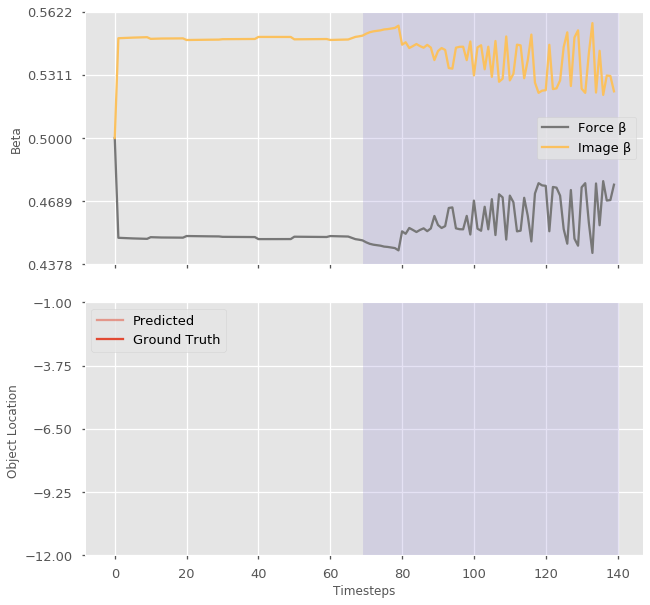

0.001154075032568817


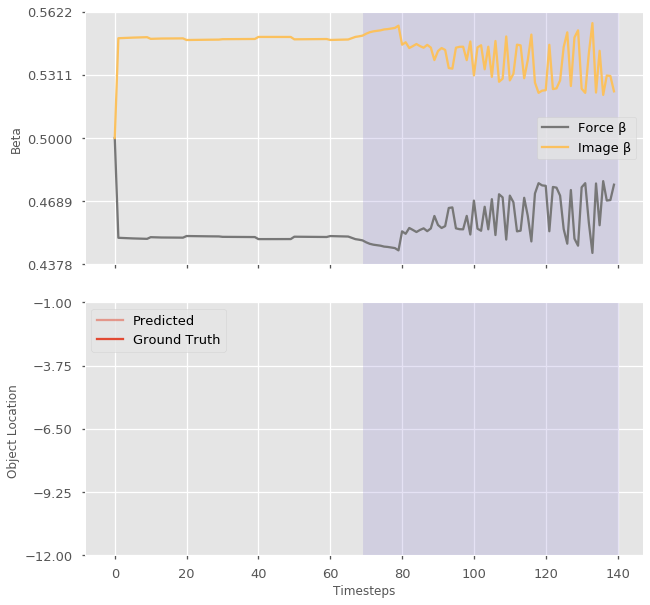

0.0006589648878252864


In [25]:
def hex_to_floats(h):
    return tuple(int(h[i:i + 2], 16) / 255. for i in (1, 3, 5)) # skip '#'

### Eval
timesteps = len(actual_states[0])

def color(i):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    return colors[i % len(colors)]

state_dim = actual_states.shape[-1]
for j in range(state_dim):
    for i, (pred, actual, particles, weights, image_betas, force_betas) in enumerate(
            zip(predicted_states, actual_states, particles_history, weights_history, image_beta_history, force_beta_history)):
        predicted_label_arg = {}
        actual_label_arg = {}
        if i == 0:
            predicted_label_arg['label'] = "Predicted"
            actual_label_arg['label'] = "Ground Truth"

        fig, (ax0, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(10,10))

        ax0.plot(
            range(timesteps),
            force_betas,
            c=color(3),
            label="Force β"
        )
        ax0.plot(
            range(timesteps),
            image_betas,
            c=color(4),
            label="Image β"
        )

        ax1.plot(range(timesteps),
                 pred[:, j],
                 c=color(i),
                 alpha=0.5,
                 **predicted_label_arg)
        ax1.plot(range(timesteps),
                 actual[:, j],
                 c=color(i),
                 **actual_label_arg)

        for t in range(0, timesteps, 2):
            particle_ys = particles[t][:, j]
            particle_xs = [t for _ in particle_ys]
            particle_alphas = weights[t]
            particle_alphas /= np.max(particle_alphas)
            particle_alphas *= 0.2
            particle_alphas += 0.02
            colors = [hex_to_floats(color(i)) + (particle_alphas[j],) for j in range(len(particle_ys))]
#             plt.scatter(particle_xs, particle_ys, c=colors)
            interval = 3
            plt.scatter(particle_xs[::interval], particle_ys[::interval], c=colors[::interval])
            #
            # for px, py, pa in zip(
            #         particle_xs, particle_ys, particle_alphas):
            #     plt.scatter([px], [py], c=color(i), alpha=pa)
        ax0.legend()    
        ax1.legend()
        ax0.axvspan(69, timesteps, alpha=0.25, color=color(2))
        ax1.axvspan(69, timesteps, alpha=0.25, color=color(2))
        ax1.set_xlabel("Timesteps")
        ax1.set_ylabel("Object Location ")
        ax0.set_ylabel("Beta")
#         ax0.set_ylim(0.2, 1.)
        ax1.set_ylim(-12,-1)
        ax1.yaxis.set_major_locator(mtick.LinearLocator(5))
        ax0.yaxis.set_major_locator(mtick.LinearLocator(5))
        plt.show()

    rmse = np.sqrt(np.mean(
        (predicted_states[:, 10:, j] - actual_states[:, 10:, j]) ** 2))
    print(rmse)

#     plt.title(f"State #{j} // RMSE = {rmse}")
#     plt.xlabel("Timesteps")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.show()

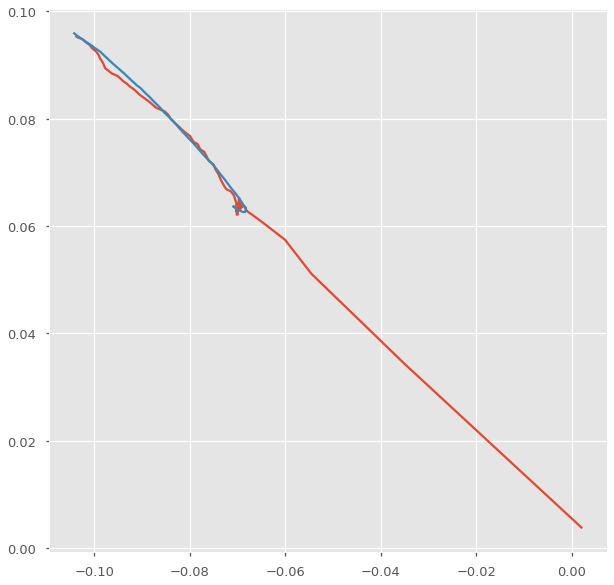

In [26]:
for i, (pred, actual, particles, weights, image_betas, force_betas) in enumerate(
        zip(predicted_states, actual_states, particles_history, weights_history, image_beta_history, force_beta_history)):
    plt.figure(figsize=(10,10))
    plt.plot(pred[:,0], pred[:,1])
    plt.plot(actual[:,0], actual[:,1])
    plt.show()

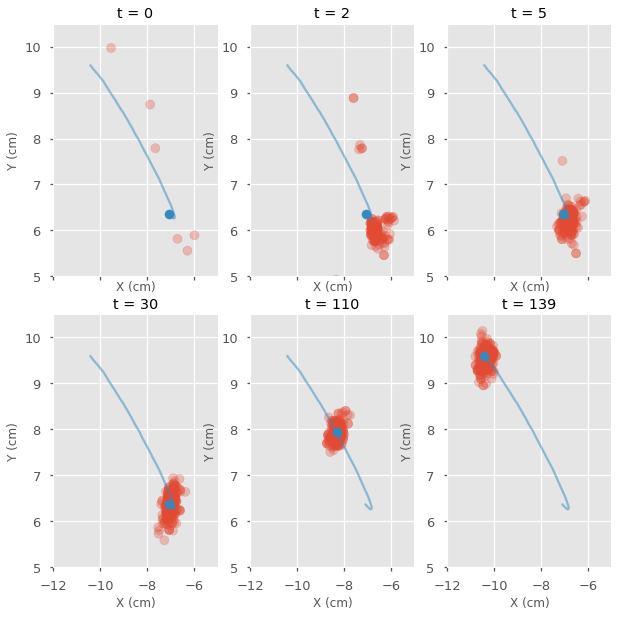

In [32]:
for i, (pred, actual, particles, weights, image_betas, force_betas) in enumerate(
        zip(predicted_states, actual_states, particles_history, weights_history, image_beta_history, force_beta_history)):
    plot_times = (0, 2, 5, 30, 110, 139)
    fig, axes = plt.subplots(2, 3, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(10,10))
    axes = axes.ravel()

    for j, t in enumerate(plot_times):
#         plt.figure(figsize=(10,10))
#         axes[j].plot(pred[:,0], pred[:,1], c=color(0), label="Predicted State", alpha=0.5)
        axes[j].plot(actual[:,0] * 100, actual[:,1] * 100, c=color(1), label="Ground-truth Trajectory", alpha=0.5)

        # Plot particles

        axes[j].set_xlim(-12, -5)
        axes[j].set_ylim(5, 10.5)

        particle_xs = particles[t][:, 0] * 100
        particle_ys = particles[t][:, 1] * 100
        particle_alphas = weights[t]
        particle_alphas /= np.max(particle_alphas)
        particle_alphas *= 0
        particle_alphas += 0.3
        colors = [hex_to_floats(color(0)) + (particle_alphas[j],) for j in range(len(particle_ys))]
        axes[j].scatter(particle_xs, particle_ys, c=colors)
#         axes[j].scatter(pred[t:t+1,0], pred[t:t+1,1], c=color(1))
        interval = 3
    #         plt.scatter(particle_xs[::interval], particle_ys[::interval], c=colors[::interval])
        axes[j].scatter(actual[t,0] * 100, actual[t,1] * 100, c=color(1), label="Ground-truth State")
        axes[j].set_title(f"t = {t}")
    #     for t in range(0, timesteps, 20):
    #         particle_xs = particles[t][:, 0]
    #         particle_ys = particles[t][:, 1]
    #         particle_alphas = weights[t]
    #         particle_alphas /= np.max(particle_alphas)
    #         particle_alphas *= 0.2
    #         particle_alphas += 0.02
    #         colors = [hex_to_floats(color(0)) + (particle_alphas[j],) for j in range(len(particle_ys))]
    #         plt.scatter(particle_xs, particle_ys, c=colors)
    #         interval = 3
    # #         plt.scatter(particle_xs[::interval], particle_ys[::interval], c=colors[::interval])
    #     plt.scatter(actual[::20,0], actual[::20,1], c=color(1))
        if j == 8:
            axes[j].legend()

        axes[j].set_xlabel("X (cm)")
        axes[j].set_ylabel("Y (cm)")
    plt.savefig("particle_2d.pdf")
    plt.show()

In [ ]:
def project(X, Y, Z):
    # Camera fov
    fov = 45. / 180. * np.pi
    # images are 96 x 96
    # tan(fov) = Y / Z = y / f
    # y / f = tan(fov)
    # f = y / tan(fov / 2)
    f = 48 / np.tan(fov / 2)
    x = -f * X / Z + 48
    y = -f * Y / Z + 48
    return x, y

from scipy.spatial.transform import Rotation as R
R_world_camera = R.from_quat([0.43, 0.43, 0.56, 0.56]).as_matrix()
t_world_camera = np.array([1.6, 0.4, 1.45])

T_world_camera = np.identity(4)
T_world_camera[:3,:3] = R_world_camera
T_world_camera[:3,3] = t_world_camera
T_camera_world = np.linalg.inv(T_world_camera)
R_camera_world = T_camera_world[:3,:3]
t_camera_world = T_camera_world[:3,3]
assert np.allclose(R_camera_world, R_world_camera.T)
assert np.allclose(t_camera_world[:,np.newaxis], -R_world_camera.T @ t_world_camera[:,np.newaxis])
    
for i, (pred, actual, particles, weights, image_betas, force_betas) in enumerate(
        zip(predicted_states, actual_states, particles_history, weights_history, image_beta_history, force_beta_history)):
#     plot_times = (0, 5, 20, 50, 80, 95, 110, 125, 139)
#     fig, axes = plt.subplots(3, 3, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(15,15))
    plot_times = (30,)
    fig, axes = plt.subplots(1, 1, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(15,15))
    axes = [axes]
#     axes = axes.ravel()
    for j, t in enumerate(plot_times):
        states, observations, controls = trajectories[0]
        axes[j].set_title(f"t = {t}")
        start_row = 20
        start_col = 8
        size = 64
        start_row = 0
        start_col = 0
        size = 96
        axes[j].imshow(observations['raw_image'][t,start_row:start_row+size,start_col:start_col+size,:])
#         axes[j].imshow(observations['raw_image'][t,:,:,:])
        axes[j].invert_yaxis()
        axes[j].set_axis_off()
        
        X = particles[t, :, 0]
        Y = particles[t, :, 1]
        Z = np.zeros_like(X) + 0.83419937

#         xyz = np.concatenate([actual[t], [0.83419937]])
#         xyz_camera = (R_camera_world @ xyz.reshape((3, 1))).flatten() + t_camera_world
#         print(xyz)
#         print(xyz_camera)
# #         xyz_camera[0] = 0
# #         xyz_camera[1] = 0
#         x, y = project(*xyz_camera)
#         print(x,y)
#         axes[j].scatter(x, y)

#         X = []
#         Y = []
#         for xx in np.linspace(0, 0.5, 4):
#             for yy in np.linspace(0, 0.5, 10):
# #                 X.append(0.43128777)
# #                 Y.append(-0.06119527)
#                 X.append(xx)
#                 Y.append(yy)
        X = np.array(X) + 0.51535153
        Y = np.array(Y) + 0.02610358
        Z = np.zeros_like(X) + 0.83419937
        
        X -= 0.5
        Y += 0.29
    
        XYZ_world = np.stack([X, Y, Z], axis=-1)
        XYZ_camera = XYZ_world @ R_camera_world.T + t_camera_world + np.array([0,0,0])
        x, y = project(XYZ_camera[:,0], XYZ_camera[:,1], XYZ_camera[:,2])
        x -= start_col
        y -= start_row
        mask = np.logical_and(
            x >= 0,
            np.logical_and(
                x <= size,
                np.logical_and(
                    y >= 0,
                    y <= size
                )
            )
        )
#         axes[j].scatter(x[mask], y[mask], alpha=0.5, c='r', marker='x')
        axes[j].scatter(x, y)

In [ ]:
traj_file = utils.TrajectoriesFile("data/gentle_push_full_images.hdf5")
with traj_file:
    print(traj_file[0]['Cylinder0_pos'][0])